In [61]:
from pgmpy.models import BayesianNetwork

from pgmpy.estimators import HillClimbSearch, BDsScore
from pgmpy.factors.discrete import State
import numpy as np
import pandas as pd

import pdb

import itertools
import pysmile
import pysmile_license

In [397]:
net2 = pysmile.Network()
net2.read_file(f"DM_screening_rel_point_cond_mut_info_linear.xdsl")
net2.clear_all_evidence()

patient_chars = {
"Age": "age_5_old_adult", 
"Sex": "M",
"SD": "SD_2_normal",
"PA": "PA_2",
"Smoking": "sm_1_not_smoker",
"BMI": "bmi_2_normal",
"Alcohol": "low",
"Diabetes": "False",
"Hypertension": "False",
}

for key, value in patient_chars.items():
    net2.set_evidence(key, value)

net2.update_beliefs()

p_crc = net2.get_node_value("CRC")[1]
p_no_crc = net2.get_node_value("CRC")[0]

vars1 = net2.get_outcome_ids("Screening")
arr = np.array(net2.get_node_value("Screening"))
df_scr = pd.DataFrame(arr.reshape(1,-1), index=["Screening"], columns=vars1)

# take column with the highest value
scr = df_scr.idxmax(axis=1).values[0]
scr_decision_patient = ["No_screening", scr]

print(f"Patient decision: {scr_decision_patient}")
print(f"Probability of CRC: {p_crc}")

Patient decision: ['No_screening', 'Stool_DNA']
Probability of CRC: 0.002235155200821302


In [709]:
u_EQ5D = {
    "age_1_young_adult": 0.966,
    "age_2_young": 0.963,
    "age_3_young_adult": 0.939,
    "age_4_adult": 0.911,
    "age_5_old_adult": 0.884,
}

def EQ5D(age):
    return u_EQ5D[age]


scr_costs_dict = {
    "No_screening": 0,
    "FIT": 14.34,
    "Blood_based": 123.13,
    "Stool_DNA": 236.88,
    "CTC": 95.41,
    "CC": 510.24,
    "Colonoscopy": 1000
}

def scr_costs(scr):
    return scr_costs_dict[scr]


sensitivity_dict = {
    "No_screening": 0,
    "gFOBT": 0.45,
    "FIT": 0.75,
    "Blood_based": 0.66,
    "Stool_DNA": 0.923,
    "CTC": 0.8,
    "CC": 0.87,
    "Colonoscopy": 0.97
}

def sensitivity(scr):
    return sensitivity_dict[scr]

specificity_dict = {
    "No_screening": 1,
    "gFOBT": 0.978,
    "FIT": 0.966,
    "Blood_based": 0.91,
    "Stool_DNA": 0.866,
    "CTC": 0.89,
    "CC": 0.92,
    "Colonoscopy": 0.99
}

def specificity(scr):
    return specificity_dict[scr]

comfort_dict = {
    "No_screening": 0,
    "gFOBT": 1,
    "FIT": 1,
    "Blood_based": 1,
    "Stool_DNA": 1,
    "CTC": 2,
    "CC": 2,
    "Colonoscopy": 3
}

def comfort(scr):
    return comfort_dict[scr]


def diff_QALY_cit(crc, r_scr):
    if crc == 1 and r_scr == 1:
        return np.random.uniform(1.3, 1.4 )
    elif crc == 1 and r_scr == 0:
        return np.random.uniform(0.8, 0.95)
    else:
        return np.random.uniform(0.993, 1.005)

def diff_QALY_gov(crc, r_scr):
    if crc == 1 and r_scr == 1:
        return np.random.uniform(10, 15 )
    elif crc == 1 and r_scr == 0:
        return np.random.uniform(0.1, 0.2)
    else:
        return np.random.uniform(0.999, 1)
    

def utility_gov(age, crc, scr, r_scr, K):
    if scr == "No_screening":
        return 30000*EQ5D(age)*diff_QALY_gov(crc, r_scr)
    else:
        return 30000*EQ5D(age)*diff_QALY_gov(crc, r_scr) - K*EQ5D(age) - scr_costs(scr) - 30000*crc*r_scr

def utility_cit(age, crc, scr, r_scr, K):
    if scr == "No_screening":
        return 30000*EQ5D(age)*diff_QALY_cit(crc, r_scr)
    else:
        return 30000*EQ5D(age)*diff_QALY_cit(crc, r_scr) + K*EQ5D(age) - scr_costs(scr)*np.random.uniform(1 - 0.9/comfort(scr), 1 - 0.6/comfort(scr))


### Citizen prob of accepting scr varying K

In [710]:
import matplotlib.pyplot as plt

def plot_histograms_count_distrib(net2, patient_chars):

    for key, value in patient_chars.items():
        net2.set_evidence(key, value)

    net2.update_beliefs()

    p_crc = net2.get_node_value("CRC")[1]
    p_no_crc = net2.get_node_value("CRC")[0]

    vars1 = net2.get_outcome_ids("Screening")
    arr = np.array(net2.get_node_value("Screening"))
    df_scr = pd.DataFrame(arr.reshape(1,-1), index=["Screening"], columns=vars1)

    # take column with the highest value
    scr = df_scr.idxmax(axis=1).values[0]
    scr_decision_patient = ["No_screening", scr]

    print(f"Optimal screening: {scr}")
    print(f"p_crc = {p_crc}")

    total_sim = 100
    count = 0
    age = patient_chars["Age"]

    

    scr_decision_patient = ["No_screening", scr]


    for ind_k, k in enumerate([0, 1, 50, 100, 200]):
        plt_arr = []
        
        for _ in range(100):
            count_arr = np.zeros(len(scr_decision_patient))
            for _ in range(total_sim):
                arr = np.array( [
                    sensitivity(scr) * p_crc * utility_cit(age, crc=1, r_scr=1, scr = scr, K=k) +
                    (1 - specificity(scr)) * p_no_crc * utility_cit(age, crc=0, r_scr=1, scr = scr, K=k)
                +
                    (1 - sensitivity(scr)) * p_crc * utility_cit(age, crc=1, r_scr=0, scr = scr, K=k) +
                    specificity(scr) * p_no_crc * utility_cit(age, crc=0, r_scr=0, scr = scr, K=k)
                for scr in scr_decision_patient] )

                argmax = np.argmax(arr)
                count_arr[argmax] += 1
                    
            p_scr = count_arr / total_sim
            plt_arr.append(p_scr)
        
        plt_arr = np.array(plt_arr)
        # for each K, plot the distribution of p_scr with a different color
        plt.hist(plt_arr[:, 1], bins = 16 , alpha=0.5, label=str(k))
        plt.legend(loc='upper right')
        plt.title("Age = " + age)
        print(f"K = {k}, mean_p_scr = {np.mean(plt_arr[:,1])}, median_p_scr = {np.median(plt_arr[:,1])}")
                    

Optimal screening: Stool_DNA
p_crc = 0.002235155200821302
K = 0, mean_p_scr = 0.39590000000000003, median_p_scr = 0.39
K = 1, mean_p_scr = 0.3992, median_p_scr = 0.4
K = 50, mean_p_scr = 0.5381999999999999, median_p_scr = 0.54
K = 100, mean_p_scr = 0.6659999999999999, median_p_scr = 0.67
K = 200, mean_p_scr = 0.8622, median_p_scr = 0.86


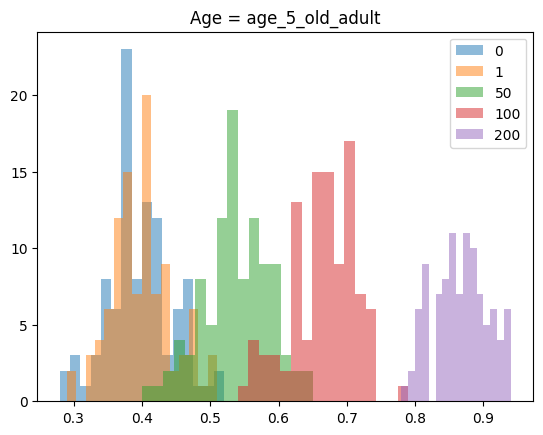

In [711]:
patient_chars = {
"Age": "age_5_old_adult", 
"Sex": "M",
"SD": "SD_2_normal",
"PA": "PA_2",
"Smoking": "sm_1_not_smoker",
"BMI": "bmi_2_normal",
"Alcohol": "low",
"Diabetes": "False",
"Hypertension": "False",
}

plot_histograms_count_distrib(net2, patient_chars)

Optimal screening: No_screening
p_crc = 0.0008431446381633401
K = 0, mean_p_scr = 0.49820000000000014, median_p_scr = 0.49
K = 1, mean_p_scr = 0.5006, median_p_scr = 0.49
K = 50, mean_p_scr = 0.5044, median_p_scr = 0.505
K = 100, mean_p_scr = 0.49450000000000005, median_p_scr = 0.5
K = 200, mean_p_scr = 0.49749999999999983, median_p_scr = 0.5


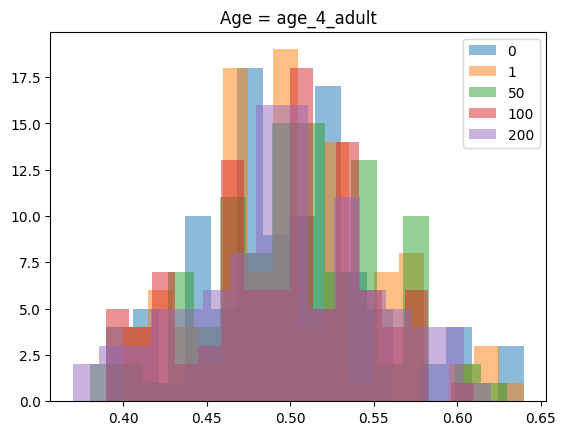

In [712]:
patient_chars = {
"Age": "age_4_adult", 
"Sex": "M",
"SD": "SD_2_normal",
"PA": "PA_2",
"Smoking": "sm_1_not_smoker",
"BMI": "bmi_2_normal",
"Alcohol": "low",
"Diabetes": "False",
"Hypertension": "False",
}

plot_histograms_count_distrib(net2, patient_chars)

### Government decision

In [713]:
net2 = pysmile.Network()
net2.read_file(f"DM_screening_rel_point_cond_mut_info_linear.xdsl")
net2.clear_all_evidence()

patient_chars = {
"Age": "age_5_old_adult", 
"Sex": "M",
"SD": "SD_2_normal",
"PA": "PA_2",
"Smoking": "sm_1_not_smoker",
"BMI": "bmi_2_normal",
"Alcohol": "low",
"Diabetes": "False",
"Hypertension": "False",
}

for key, value in patient_chars.items():
    net2.set_evidence(key, value)

net2.update_beliefs()

p_crc = net2.get_node_value("CRC")[1]
p_no_crc = net2.get_node_value("CRC")[0]

vars1 = net2.get_outcome_ids("Screening")
arr = np.array(net2.get_node_value("Screening"))
df_scr = pd.DataFrame(arr.reshape(1,-1), index=["Screening"], columns=vars1)

# take column with the highest value
scr = df_scr.idxmax(axis=1).values[0]
scr_decision_patient = ["No_screening", scr]



# ---------------------- Run the Simulation ----------------------
total_sim = 300
age = patient_chars["Age"]

n_K_points = 20
upper_K = 500
n_random_trials = 1000

v_scr_K_iter = []

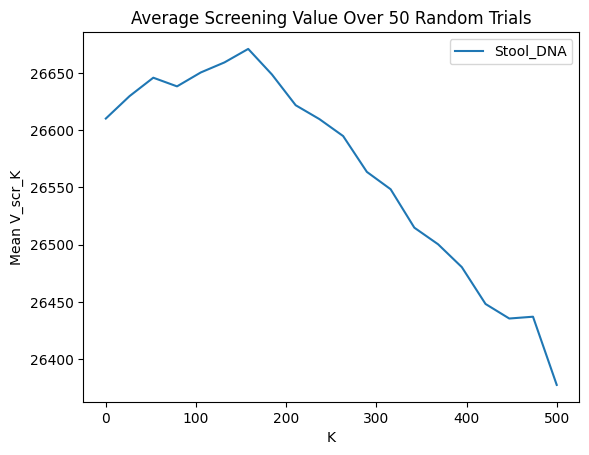

In [714]:
n_random_trials = 50
for _ in range(n_random_trials):
    p_no_crc = 1 - p_crc
    scr_decision_patient = ["No_screening", scr]

    v_x_K_arr = np.zeros((n_K_points,))

    for ind_k, k in enumerate(np.linspace(1, upper_K, n_K_points)):
        count_arr = np.zeros(len(scr_decision_patient))
        for _ in range(total_sim):

            arr = np.array( [
                    sensitivity(scr) * p_crc * utility_cit(age, crc=1, r_scr=1, scr = scr, K=k) +
                    (1 - specificity(scr)) * p_no_crc * utility_cit(age, crc=0, r_scr=1, scr = scr, K=k)
                +
                    (1 - sensitivity(scr)) * p_crc * utility_cit(age, crc=1, r_scr=0, scr = scr, K=k) +
                    specificity(scr) * p_no_crc * utility_cit(age, crc=0, r_scr=0, scr = scr, K=k)
                for scr in scr_decision_patient] )

            argmax = np.argmax(arr)
            count_arr[argmax] += 1
        
        p_scr_K = count_arr / total_sim


        v_x_K = [ p_scr_K[i] * (
            sensitivity(scr) * p_crc * utility_gov(age, crc=1, r_scr=1, scr = scr, K=k) +
            (1 - specificity(scr)) * p_no_crc * utility_gov(age, crc=0, r_scr=1, scr = scr, K=k)
        +  
            (1 - sensitivity(scr)) * p_crc * utility_gov(age, crc=1, r_scr=0, scr = scr, K=k) +
            specificity(scr) * p_no_crc * utility_gov(age, crc=0, r_scr=0, scr = scr, K=k)
        ) for i, scr in enumerate(scr_decision_patient)] 


        v_x_K_arr[ind_k] = sum(v_x_K)

    opt_val_loc = np.argmax(v_x_K_arr)
    opt_K = np.linspace(1, upper_K, n_K_points)[opt_val_loc]

    v_scr_K_iter.append(v_x_K_arr)

summ_v_scr_K_iter = np.mean(np.stack(v_scr_K_iter), axis = 0)
plt.plot(np.linspace(0, upper_K, n_K_points), summ_v_scr_K_iter, label = scr)
plt.legend(loc='upper right')
plt.xlabel("K")
plt.ylabel("Mean V_scr_K")
plt.title(f"Average Screening Value Over {n_random_trials} Random Trials")
plt.show()

### Pruebas

In [392]:
#CITIZEN
k = 30

arr = np.array( [
                    sensitivity(scr) * p_crc * utility_cit(age, crc=1, r_scr=1, scr = scr, K=k) +
                    (1 - specificity(scr)) * p_no_crc * utility_cit(age, crc=0, r_scr=1, scr = scr, K=k)
                +
                    (1 - sensitivity(scr)) * p_crc * utility_cit(age, crc=1, r_scr=0, scr = scr, K=k) +
                    specificity(scr) * p_no_crc * utility_cit(age, crc=0, r_scr=0, scr = scr, K=k)
                for scr in scr_decision_patient] )

arr

array([-15.7728533 , -34.69799342])

In [393]:
count_arr = np.zeros(len(scr_decision_patient))
for _ in range(total_sim):

    arr = np.array( [
            sensitivity(scr) * p_crc * utility_cit(age, crc=1, r_scr=1, scr = scr, K=k) +
            (1 - specificity(scr)) * p_no_crc * utility_cit(age, crc=0, r_scr=1, scr = scr, K=k)
        +
            (1 - sensitivity(scr)) * p_crc * utility_cit(age, crc=1, r_scr=0, scr = scr, K=k) +
            specificity(scr) * p_no_crc * utility_cit(age, crc=0, r_scr=0, scr = scr, K=k)
        for scr in scr_decision_patient] )

    argmax = np.argmax(arr)
    count_arr[argmax] += 1

p_scr_K = count_arr / total_sim

p_scr_K

array([0.58, 0.42])

In [395]:
#GOVERNMENT

arr = [ (
            sensitivity(scr) * p_crc * utility_gov(age, crc=1, r_scr=1, scr = scr, K=k) +
            (1 - specificity(scr)) * p_no_crc * utility_gov(age, crc=0, r_scr=1, scr = scr, K=k)
        +  
            (1 - sensitivity(scr)) * p_crc * utility_gov(age, crc=1, r_scr=0, scr = scr, K=k) +
            specificity(scr) * p_no_crc * utility_gov(age, crc=0, r_scr=0, scr = scr, K=k)
        ) for scr in scr_decision_patient]

arr

[-49.43167698534271, 478.2628953090798]

In [396]:

arr = [ p_scr_K[i] * (
            sensitivity(scr) * p_crc * utility_gov(age, crc=1, r_scr=1, scr = scr, K=k) +
            (1 - specificity(scr)) * p_no_crc * utility_gov(age, crc=0, r_scr=1, scr = scr, K=k)
        +  
            (1 - sensitivity(scr)) * p_crc * utility_gov(age, crc=1, r_scr=0, scr = scr, K=k) +
            specificity(scr) * p_no_crc * utility_gov(age, crc=0, r_scr=0, scr = scr, K=k)
        ) for i, scr in enumerate(scr_decision_patient)]


arr

[np.float64(-13.584540345479917), np.float64(131.72820782487042)]

In [133]:
K = 1
U_C0_I0 = utility_cit(age, crc = 0, scr = 0, K = K)
U_C0_I1 = utility_cit(age, crc = 0, scr = 1, K = K)
U_C1_I0 = utility_cit(age, crc = 1, scr = 0, K = K)
U_C1_I1 = utility_cit(age, crc = 1, scr = 1, K = K)

print(U_C0_I0, U_C0_I1, U_C1_I0, U_C1_I1)


if U_C1_I1 * p_crc + U_C0_I1 * p_no_crc > U_C1_I0 * p_crc + U_C0_I0 * p_no_crc:
    print("Screening")

72.98620006592377 44.086818497300484 17.894905470606222 31.829246652293236


In [126]:
30000*EQ5D(age)*QALY(0, 0) / 365

71.99053644113627